# Introduction

This is a simplification of my figuring out how to submit seqspec files to the IGVF DACC.

- [Python environment](#Setup)
- [Seqspec template function](#Template)
- [Working out steps needed to create seqspec objects](#Working-out-steps-needed-to-create-seqspec-objects)
- [Exploring boto3](#Exploring-boto3)
- [Seqspec submission functions](#Seqspec-Submission-functions)
- [Create seqspec objects for remaining fastqs](#Create-seqspec-objects-for-remaining-fastqs)

# Setup

First we start with general imports

In [1]:
import hashlib
import requests
from pathlib import Path
from io import StringIO, BytesIO
import sys
import json
from jsonschema import Draft4Validator
import pandas
import os
import sys
from urllib.parse import urlparse
import yaml

In [2]:
try:
    import boto3
except ImportError:
    !{sys.executable} -m pip install --user boto3
    import boto3
    
from botocore.exceptions import ClientError
    

In [3]:
try:
    from jinja2 import Environment, FileSystemLoader, select_autoescape
except ImportError:
    !{sys.executable} -m pip install --user jinja2
    from jinja2 import Environment, FileSystemLoader, select_autoescape


env = Environment(
    loader=FileSystemLoader("templates"),
    autoescape=select_autoescape()
)

I want to be able to use the seqspec validator while I was writing my seqspec file.

I have the repository checked out into ~/proj/seqspec. This block should either import it for me, or install it if someone elese runs it.

In [4]:
try:
    import seqspec
except ImportError:
    seqspec_root = Path("~/proj/seqspec").expanduser()
    if seqspec_root.exists() and str(seqspec_root) not in sys.path:
        sys.path.append(str(seqspec_root))
    else:
        !{sys.executable} -m pip install --user seqspec
    import seqspec

Import pieces of seqspec that we need for this notebook.

In [5]:
from seqspec.Assay import Assay
from seqspec.Region import Region
from seqspec.Region import Onlist
from seqspec.utils import load_spec_stream
from seqspec.seqspec_print import run_print_tree, run_print_png
from seqspec.seqspec_onlist import run_list_onlists, run_onlist, run_find_by_type

I have my own API for interacting with the IGVF database server (which is very much like the old ENCODE database server)

In [6]:
try:
    from encoded_client import encoded
except ImportError:
    encoded_root = Path("~/proj/encoded_client").expanduser()
    if encoded_root.exists() and str(encoded_root) not in sys.path:
        sys.path.append(str(encoded_root))
    else:
        !{sys.executable} -m pip install --user encoded_client
        
    from encoded_client import encoded

encoded_client will pull submitter credentials from either DCC_API_KEY and DCC_SECRET_KEY or from a .netrc file loaded from your home directory. (replacing the {DCC_API_KEY} and {DCC_SECRET_KEY} strings with your specific values.)

The format of a .netrc file is a plain text file with records of the format:

<pre>machine api.sandbox.igvf.org login {DCC_API_KEY} password {DCC_SECRET_KEY}</pre>

Or api.data.igvf.org

(it's also possible to list the fields on separate lines, but I think it's easier to read when they're on one line)

or after creating the server object call:

<pre>server.username = "{DCC_API_KEY}"
server.password = "{DCC_SECRET_KEY}"</pre>



## submission variables

In [7]:
server_name = "api.sandbox.igvf.org"
award = "/awards/HG012077/"
lab = "/labs/ali-mortazavi/"


In [8]:
server = encoded.ENCODED(server_name)
igvf_validator = encoded.DCCValidator(server)

In [9]:
def seqspec_validate(schema, spec):
    """Validate a yaml object against a json schema
    """
    validator = Draft4Validator(schema)

    for idx, error in enumerate(validator.iter_errors(spec), 1):
        print(f"[{idx}] {error.message}")

In [10]:
schema_path = seqspec_root / "seqspec"/ "schema" / "seqspec.schema.json"

with open(schema_path, "rt") as instream:
    seqspec_schema = json.load(instream)

In [11]:
def load_spec(filename):
    with open(filename, "rt") as instream:
        data = yaml.load(instream, Loader=yaml.Loader)
        for r in data.assay_spec:
            r.set_parent_id(None)
    return data

# Template

First build up lists of barcodes onlists needed for this protocol the names will be passed to the template.

In [12]:
barcode_sets = {
    "parse-wt-v2": {
        # onlist1_n96_v4
        #"barcode_1_url": "https://data.igvf.org/tabular-files/IGVFFI0924TKJO/@@download/IGVFFI0924TKJO.txt.gz",
        "barcode_1_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc1_n96_v4.txt.gz",        
        "barcode_1_md5": "6d5016e63f121b6a64fb3907dd83f358",
        #"barcode_2_url": "https://data.igvf.org/tabular-files/IGVFFI1138MCVX/@@download/IGVFFI1138MCVX.txt.gz",
        "barcode_2_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz",
        "barcode_2_md5": "1452e8ef104e6edf686fab8956172072",
        #"barcode_3_url": "https://data.igvf.org/tabular-files/IGVFFI1138MCVX/@@download/IGVFFI1138MCVX.txt.gz",
        "barcode_3_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz",
        "barcode_3_md5": "1452e8ef104e6edf686fab8956172072",
    },
    "parse-wt-mega-v2": {
        # need to add barcode urls
        #onlist1_n192_v4
        #"barcode_1_url": "https://data.igvf.org/tabular-files/IGVFFI2591OFQO/@@download/IGVFFI2591OFQO.txt.gz",
        "barcode_1_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc1_n192_v4.txt.gz",
        "barcode_1_md5": "5c3b70034e9cef5de735dc9d4f3fdbde",
        #"barcode_2_url": "https://data.igvf.org/tabular-files/IGVFFI1138MCVX/@@download/IGVFFI1138MCVX.txt.gz",
        "barcode_2_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz",
        "barcode_2_md5": "1452e8ef104e6edf686fab8956172072",
        #"barcode_3_url": "https://data.igvf.org/tabular-files/IGVFFI1138MCVX/@@download/IGVFFI1138MCVX.txt.gz",
        "barcode_3_url": "https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz",
        "barcode_3_md5": "1452e8ef104e6edf686fab8956172072",
    }
}

library_kits = {
    "parse-wt-v2": {
        "single": {
            "library_protocol": "Evercode WT single index v2",
            "library_kit": "Evercode WT v2.0.1 single index",
        },
        "dual": {
            "library_protocol": "Evercode WT single index v2",
            "library_kit": "Evercode WT v2.0.1 single index",
        },
    },
    "parse-wt-mega-v2": {
        "single": {
            "library_protocol": "Evercode mega WT dual index v2",
            "library_kit": "Evercode WT Mega v2.0.1 dual index",
        },
        "dual": {
            "library_protocol": "Evercode mega WT dual index v2",
            "library_kit": "Evercode WT Mega v2.0.1 dual index",
        }
    }
}

sequencing_platform = {
    # Illumina novaseq 6000
    "/platform-terms/EFO_0008637/": {
        "sequence_protocol": "Illumina NovaSeq 6000",
        "sequence_kit": "https://www.illumina.com/products/by-type/sequencing-kits/cluster-gen-sequencing-reagents/novaseq-reagent-kits.html",        
    },
    # Illumina NextSeq 2000
    "/platform-terms/EFO_0010963/": {
        "sequence_protocol": "Illumina NextSeq 2000",
        "sequence_kit": "https://www.illumina.com/products/by-type/sequencing-kits/cluster-gen-sequencing-reagents/nextseq-1000-2000-reagents.html",
    }
}

Define the the file information needed to define this seqspec.

In [13]:
p5_length = 29
truseq_read1_length = 29
read1_min_length = 140
read2_min_length = 86
truseq_read2_length = 34
i7_length = 8
p7_length = 24
total_min_length = p5_length + truseq_read1_length + read1_min_length + read2_min_length + truseq_read2_length + p7_length
context = {
    # attributes to use 
    # accession
    # s3_uri
    # minimum_read_length
    # maximum_read_length
    "read1_accession": "TSTFI76281026",
    "read1_url": server.prepare_url("/sequence-files/TSTFI76281026/@@download/TSTFI76281026.fastq.gz"),
    "read1_min_length": read1_min_length,
    "read1_max_length": read1_min_length,

    "read2_accession": "TSTFI85921201",
    "read2_url": server.prepare_url("/sequence-files/TSTFI85921201/@@download/TSTFI85921201.fastq.gz"),
    "read2_min_length": read2_min_length,
    "read2_max_length": read2_min_length,
    
    "total_min_length": total_min_length,
    "total_max_length": total_min_length,
}

# Merge in the barcode information
context.update(barcode_sets["parse-wt-mega-v2"])

# Merge in the library information
context.update(library_kits["parse-wt-mega-v2"]["single"])

# Merge in sequencer information
# nextseq
context.update(sequencing_platform["/platform-terms/EFO_0010963/"])

# load the template and instantiate it with the context for this specific measurement set.
# this version needs the libspec branch that separates the sequence and library specifications
# parse_wt_mega_v2 = env.get_template("parse-wt-mega-v2-single-index-libspec-1.yaml.j2")

# this version needs the original version that merges the sequence and library specification concepts
parse_wt_mega_v2 = env.get_template("parse-wt-mega-v2-single-index-seqspec-0.yaml.j2")

example_yaml = parse_wt_mega_v2.render(context)

# validate the generated seqspec file.
example_spec = load_spec_stream(StringIO(example_yaml))
seqspec_validate(seqspec_schema, example_spec.to_dict())

# Print the example for evaluation.
print(example_yaml)

!Assay
seqspec_version: 0.0.0
assay_id: Evercode-WT-mega-single-index-v2
name: Parse Evercode mega WT v2 using single illumina multiplex index
doi: https://www.protocols.io/view/evercode-wt-mega-v2-2-1-8epv5xxrng1b/v1?step=21
date: 08 November 2023
description: split-pool ligation-based transcriptome sequencing
modalities:
  - rna
# can lib_struct be optional?
lib_struct: ""
library_protocol: Evercode mega WT dual index v2
library_kit: Evercode WT Mega v2.0.1 dual index
sequence_protocol: Illumina NextSeq 2000
sequence_kit: https://www.illumina.com/products/by-type/sequencing-kits/cluster-gen-sequencing-reagents/nextseq-1000-2000-reagents.html
  
# TODO what strand are the Read one and two on? I'm just following the
# example I don't really know
sequence_spec:
  - !Read
    read_id: TSTFI76281026.fastq.gz
    name: Read 1 fastq for TSTFI76281026
    modality: rna
    primer_id: trueseq_read1
    min_len: 140
    max_len: 140
    strand: pos
  - !Read
    read_id: TSTFI85921201.fastq.gz

In [14]:
print(run_print_tree(example_spec))

                                            ┌─'illumina_p5:29'
                                            ├─'truseq_read1:29'
                                            ├─'TSTFI76281026:140'
                                            │                     ┌─'barcode-1:8'
                                            │                     ├─'linker-1:30'
                                            │                     ├─'barcode-2:8'
───────────────────── ──rna─────────────────┼─TSTFI85921201───────┤
                                            │                     ├─'linker-3:22'
                                            │                     ├─'barcode-3:8'
                                            │                     └─'umi:10'
                                            ├─'truseq_read2:34'
                                            ├─'index7:8'
                                            └─'illumina_p7:24'


/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


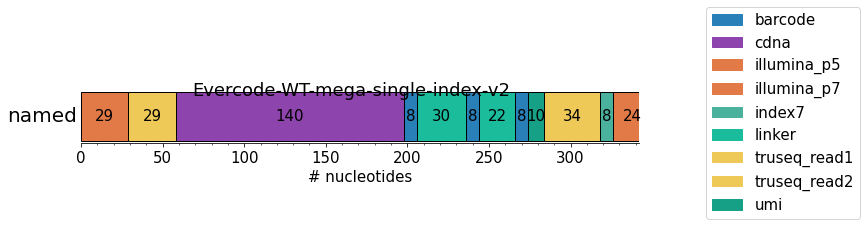

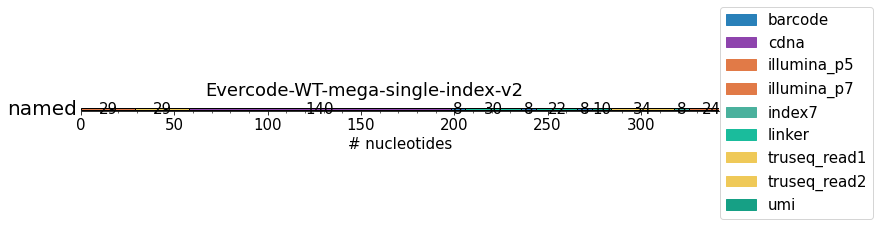

In [15]:
run_print_png(example_spec)

In [16]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [17]:
run_list_onlists(example_spec, "rna")

[{'region_id': 'barcode-1',
  'filename': 'https://woldlab.caltech.edu/~diane/parse_barcodes/bc1_n192_v4.txt.gz',
  'location': 'remote',
  'md5': '5c3b70034e9cef5de735dc9d4f3fdbde'},
 {'region_id': 'barcode-2',
  'filename': 'https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz',
  'location': 'remote',
  'md5': '1452e8ef104e6edf686fab8956172072'},
 {'region_id': 'barcode-3',
  'filename': 'https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz',
  'location': 'remote',
  'md5': '1452e8ef104e6edf686fab8956172072'}]

In [18]:
example_spec.get_modality("rna").get_region_by_type("barcode")

[{'region_id': 'barcode-1', 'region_type': 'barcode', 'name': 'barcode-1', 'sequence_type': 'onlist', 'onlist': {'filename': 'https://woldlab.caltech.edu/~diane/parse_barcodes/bc1_n192_v4.txt.gz', 'location': 'remote', 'md5': '5c3b70034e9cef5de735dc9d4f3fdbde'}, 'sequence': 'NNNNNNNN', 'min_len': 8, 'max_len': 8, 'regions': None},
 {'region_id': 'barcode-2', 'region_type': 'barcode', 'name': 'barcode-2', 'sequence_type': 'onlist', 'onlist': {'filename': 'https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz', 'location': 'remote', 'md5': '1452e8ef104e6edf686fab8956172072'}, 'sequence': 'NNNNNNNN', 'min_len': 8, 'max_len': 8, 'regions': None},
 {'region_id': 'barcode-3', 'region_type': 'barcode', 'name': 'barcode-3', 'sequence_type': 'onlist', 'onlist': {'filename': 'https://woldlab.caltech.edu/~diane/parse_barcodes/bc2_v1_bc_v3.txt.gz', 'location': 'remote', 'md5': '1452e8ef104e6edf686fab8956172072'}, 'sequence': 'NNNNNNNN', 'min_len': 8, 'max_len': 8, 'regions': None}]

In [19]:
joined_name = run_onlist(example_spec, "rna", "barcode")

In [20]:
if joined_name is not None:
    joined = pandas.read_csv("onlist_joined.txt")
    print("length = ", joined.shape[0])
    joined.head()

length =  1769471


In [21]:
!rm onlist_joined.txt

In [22]:
assert False

AssertionError: 

I have submission spreadsheets very similar to the IGVF DACC google sheet, but stored on our groups server as .xlsx files. These nextcloud urls will remotely download the spreadsheet.

The parts of the sheet that are used is:

<table>
    <tr>

In [ ]:
submitted_book_names = {
    "igvftst": {
        "IGVF_b01": "https://woldlab.caltech.edu/nextcloud/index.php/s/5cJteSWgitN5BDM/download",
    }
}

sequence_file = pandas.read_excel(submitted_book_names["igvftst"]["IGVF_b01"], "sequence_file")

# Working out steps needed to create seqspec objects

Here I am testing a set of pandas filters to make sure that I can pair the already submitted fastqs correctly.

In [ ]:
dry_run = True

In [ ]:
for i, read1 in sequence_file[sequence_file["illumina_read_type"] == "R1"].iterrows():
    file_set_filter = (sequence_file["file_set"] == read1.file_set)
    flowcell_filter = (sequence_file["flowcell_id"] == read1.flowcell_id)
    lane_filter = (sequence_file["lane:integer"] == read1["lane:integer"])
    read2_filter = (sequence_file["illumina_read_type"] == "R2")
    read2s = sequence_file[file_set_filter & flowcell_filter & lane_filter & read2_filter]
    assert read2s.shape[0] == 1
    read2 = read2s.loc[read2s.first_valid_index()]
    print(i, read1.file_set, read1.accession, read2.accession, read1.md5sum)


Now that we know what sets of files are supposed to be grouped together with which dataset, we can test, a single seqspec file.

In [ ]:
read1 = "TSTFI61612395"
read2 = "TSTFI25832476"
file_set = "ali-mortazavi:B01_13A_illumina"

example_yaml = generate_parse_wt_yaml(read1, read2)
example_spec = load_spec_stream(StringIO(example_yaml))
seqspec_validate(seqspec_schema, example_spec.to_dict())

md5 = hashlib.md5(example_yaml.encode('utf-8'))

seqspec_file = {
    "award": award,
    "lab": lab,
    "md5sum": md5.hexdigest(),
    "file_format": "yaml",
    "file_set": file_set,
    "content_type": "seqspec"
}
igvf_validator.validate(seqspec_file, "configuration_file")

try:
    print(server.get_json("md5:{}".format(seqspec_file["md5sum"])))
except encoded.HTTPError as err:
    if err.response.status_code == 404:
        print("Should upload")
        # This posts the metadata to describe the seqspec file to the configuration_file collection.
        # post_json turns into calls 
        # requests.post(
        #   "https://api.sandbox.igvf.org/configuration_file",
        #   auth=(token,,key), 
        #   headers={"content-type": "application/json", "accept": "application/json"},
        #   data=seqspec_file)
        #if not dry_run:
        #    print(server.post_json("configuration_file", seqspec_file))

In [ ]:
seqspec_file

# Seqspec Submission functions

Now that we've done it in stages for one pair of fastqs, lets turn it into a program.

In [ ]:
def parse_s3_url(url):
    """Extract out the path portion of a s3 uri
    """
    url = urlparse(url)
    assert url.scheme == "s3", "Not s3 url {}".format(url)
    
    return url.netloc, url.path[1:]

def post_seqspec(seqspec_metadata, seqspec_contents):
    """Post a seq spec metadata object to the portal and upload the seqspec object as a file to s3
    """
    response = server.post_json("configuration_file", seqspec_metadata)

    if len(graph) != 1:
        print("Strange number of result objects {}".format(len(graph)))

    graph = response["@graph"][0]
    credentials = graph["upload_credentials"]
    
    s3_client = boto3.client(
        's3', 
        aws_access_key_id=credentials["access_key"], 
        aws_secret_access_key=credentials["secret_key"], 
        aws_session_token=credentials["session_token"])

    bucket, target = parse_s3_url(credentials["upload_url"])
    s3_client.upload_fileobj(
        BytesIO(seqspec_contents.encode("utf-8")),
        bucket,
        target)

    return response

def register_seqspec(file_set, read1, read2, dry_run=True):
    """Create the seqspec objects and attach them to the fastqs
    
    Paramweters:
    - file_set: id the seqspec should be attached to
    - read1, read2: the two fastq ids for the paired end RNA-seq reads.
    
    Other assays might need more options like the I1 read or customizing 
    the read lengths
    """
    
    # Generate the seqspec yaml data and load it into the seqspec objects
    seqspec_contents = generate_parse_wt_yaml(read1, read2)
    example_spec = load_spec_stream(StringIO(seqspec_contents))
    
    # Validate the seqspec against the seqspec schema.
    # this is depending on a global variable for the schema
    seqspec_validate(seqspec_schema, example_spec.to_dict())

    # Generate a MD5 sum for the seqspec yaml file
    md5 = hashlib.md5(seqspec_contents.encode('utf-8'))

    # Construct the configuration_file object for the DACC portal
    seqspec_metadata = {
        "award": award,
        "lab": lab,
        "md5sum": md5.hexdigest(),
        "file_format": "yaml",
        "file_set": file_set,
        "content_type": "seqspec"
    }
    # Make sure the configuration_file passes the DACCs schema
    igvf_validator.validate(seqspec_metadata, "configuration_file")

    # Search the portal for the md5sum of our seqspec file to see if 
    # it has already been submitted
    try:
        response = server.get_json("md5:{}".format(seqspec_metadata["md5sum"]))
        print("found object by {}".format(seqspec_metadata["md5sum"]))
        print(response)
        seqspec_metadata.update({
            "@id": response["@id"],
            "accession": response["accession"],
            "uuid": response["uuid"],
        })
    except encoded.HTTPError as err:
        # If the file has not been submitted, and we're not in dry_run mode 
        # lets submit it
        if err.response.status_code == 404:
            if dry_run:
                print("Would upload {}".format(md5.hexdigest()))
            else:
                response = post_seqspec(seqspec_metadata, seqspec_contents)
                if response["status"] == "success":
                    graph = reponse["@graph"][0]
                    print("Upload of {} succeeded". format(graph["@id"]))
                    seqspec_metadata.update({
                        "@id": graph["@id"],
                        "accession": graph["accession"],
                        "uuid": graph["uuid"],
                    })
                else:
                    print(response)
                    raise RuntimeError("Unable to create metadata object")

        else:
             print("Other HTTPError error {}".format(err.response.status_code))

    # Once the seqspec configuration file and metadata has been created and uploaded
    # attach the the configuration file to it's fastqs.
    for read in [read1, read2]:
        read_id = "/sequence-files/{}/".format(read)
        fileinfo = server.get_json(read_id.format(read))
        print(fileinfo)
        if not "seqspec" in fileinfo:
            print("Need to post seqspec")
            if not dry_run:
                print(server.patch_json(read_id, {"seqspec": seqspec_metadata["@id"]}))
        elif fileinfo["seqspec"] != seqspec_metadata["@id"]:
            print("WARNING: seqspec accessions do not match, {} {}".format(fileinfo["seqspec"], seqspec_metadata["@id"]))

    return seqspec_metadata

# Testing submission functions

Test the register_seqspec function with the next set of files.

In [ ]:
read1 = "TSTFI61612395"
read2 = "TSTFI25832476"
file_set = "ali-mortazavi:B01_13A_illumina"
register_seqspec(file_set, read1, read2, dry_run=True)

# Create seqspec objects for remaining fastqs

Now that we have a way to list all of the fastq sets, and a function to post everything to the portal
loop through all of our fastqs posting the seqspec configuration files

In [ ]:
submitted = []

for i, read1 in sequence_file[sequence_file["illumina_read_type"] == "R1"].iterrows():
    file_set_filter = (sequence_file["file_set"] == read1.file_set)
    flowcell_filter = (sequence_file["flowcell_id"] == read1.flowcell_id)
    lane_filter = (sequence_file["lane:integer"] == read1["lane:integer"])
    read2_filter = (sequence_file["illumina_read_type"] == "R2")
    read2s = sequence_file[file_set_filter & flowcell_filter & lane_filter & read2_filter]
    assert read2s.shape[0] == 1
    read2 = read2s.loc[read2s.first_valid_index()]
    #print(i, read1.file_set, read1.accession, read2.accession, read1.md5sum)
    
    submitted.append(register_seqspec(read1.file_set, read1.accession, read2.accession, dry_run=True))


Convert the results of creating into a pandas data frame so I can store the return values in a my submission spreadsheet.

In [ ]:
pandas.DataFrame(submitted)[["accession", "uuid", "file_set", "content_type", "file_format", "md5sum", "award", "lab"]]
